# TEST MIXUP CODE

In [198]:
import torch
import numpy as np
print(torch.__version__)
def mixup(x, y, alpha):
    y = torch.nn.functional.one_hot(y, num_classes = 41)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, lam * y + (1 - lam) * y[index, :]
    return mixed_x, y_a.float(), y_b.float(), lam

x = torch.rand(64, 100) # random I don't care at the moment
y = torch.randint(low = 0, high = 41, size = (64,), dtype = torch.long)
print(y.shape)
mixed_x, original_labels, mixup_labels, lam = mixup(x, y, alpha = 0.2)
print("Lambda: {}".format(lam))

random_feature_vector = torch.rand(64, 41)
print(mixup_labels.shape)
print(torch.nn.functional.cross_entropy(random_feature_vector, mixup_labels))



2.2.0
torch.Size([64])
Lambda: 0.9201882276187555
torch.Size([64, 41])
tensor(3.7785)


# Visualization of Mel Spec - Attention Maps - Wavegrams

In [12]:
import torch
import librosa as lb
import matplotlib.pyplot as plt
from model import Wavegram_AttentionMap
from data import TUTDatamodule
import numpy as np

train_data = "TUT Anomaly detection/train"
test_data = "TUT Anomaly detection/test"
datamodule = TUTDatamodule(path_train = train_data, path_test = test_data, sample_rate = 16000, duration = 10, percentage_val = 0.05, batch_size = 16)

ckpt_model = "MWM_93.44_s40_m0.7.ckpt"
model = Wavegram_AttentionMap.load_from_checkpoint(ckpt_model, lr = 0.001, h = 128)
test_dataloader = datamodule.test_dataloader()
batch = next(iter(test_dataloader))
x, metadata, label, numerical_label = batch
predicted, _, reppr, features, heatmap = model.forward(x.cuda(), metadata.cuda())
list_mel_spec = []
list_wavegrams = []
list_attention_map_0 = []
list_attention_map_1 = []
list_labels = []
list_metadata = []
list_predictions = []
list_features = []
model.eval()
with torch.no_grad():
    for element in range(x.shape[0]): # for each element in the batch
        if label[element] == 1:
            list_labels.append(label[element])
            list_predictions.append(predicted[element].cpu().numpy())
            list_features.append(features[element].cpu().numpy())
            list_wavegrams.append(reppr[element, 1].cpu().numpy())
            list_mel_spec.append(reppr[element, 0].cpu().numpy())
            list_attention_map_0.append(heatmap[element, 0].cpu().numpy())
            list_attention_map_1.append(heatmap[element, 1].cpu().numpy())
            list_metadata.append(metadata[element].cpu().numpy())



13
[16.305506  16.064363  19.173454  16.471077  16.280447  17.503225
 16.320068  14.739185  15.695382  17.791506  16.29814   16.749043
 17.604982  -7.4268303 15.106727  32.010796  16.436003  19.984148
 19.608175  20.30397   16.777174  16.759487  14.950047  17.797243
 17.194408  16.753605  16.318556  17.514292  12.098692  17.921518
 12.444644  12.251544  10.660732  15.869027  20.172062  22.857477
 22.865456  18.157253  16.281126  18.537788  21.326706 ]
tensor(1)


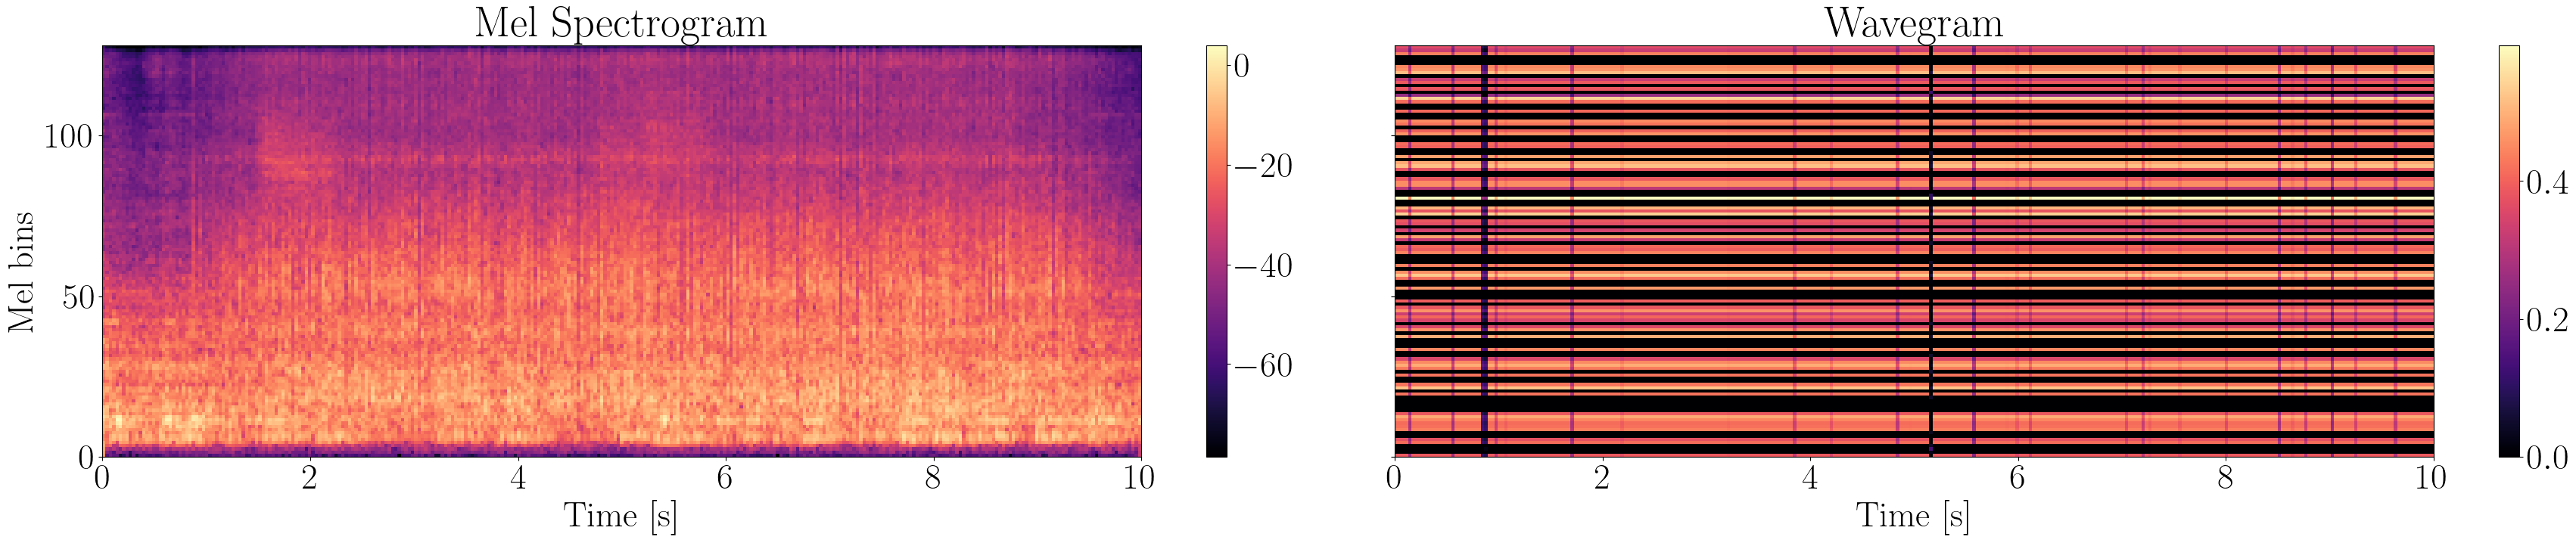

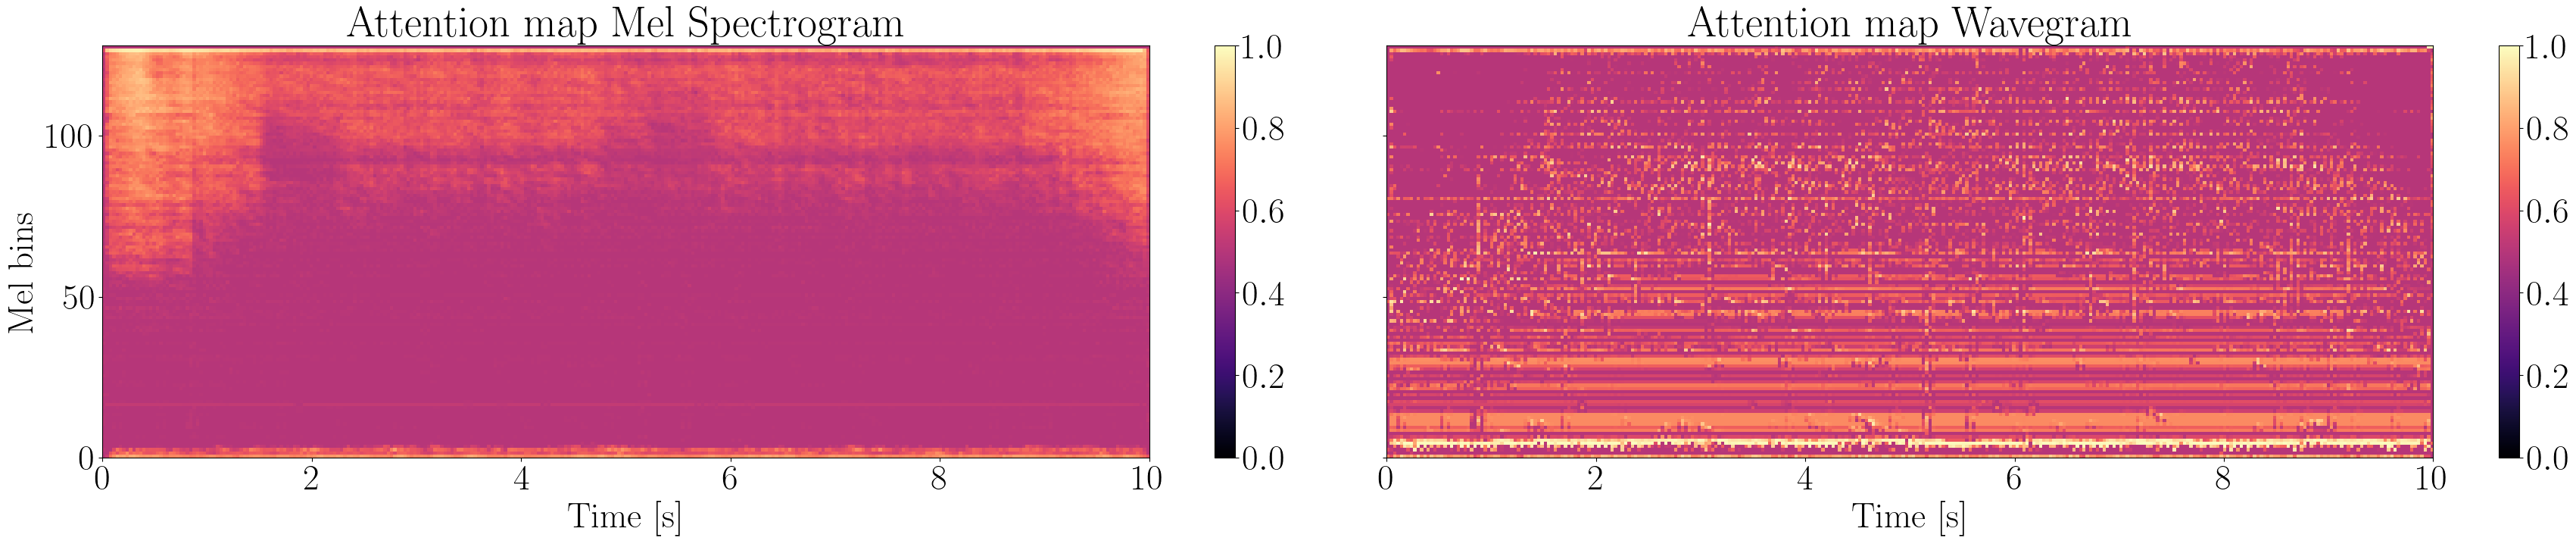

In [20]:
time_steps = np.linspace(0, 10, list_mel_spec[0].shape[1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 34
plt.rcParams['text.usetex'] = True
random_sample = torch.randint(low = 0, high = len(list_labels), size = (1,))
fig, axs = plt.subplots(1, 2, figsize = (36, 8), sharex = True, sharey = True)

im = axs[0].imshow(list_mel_spec[random_sample], aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(), 0, list_mel_spec[0].shape[0]], cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[0])
axs[0].set_title('Mel Spectrogram')
axs[0].set_xlabel('Time [s]')
im = axs[1].imshow(list_wavegrams[random_sample], aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, list_mel_spec[0].shape[0]], cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[1])
axs[1].set_title('Wavegram')
axs[1].set_xlabel('Time [s]')


fig.text(0, 0.5, 'Mel bins', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("spec-wav.pdf", transparent = True, dpi = 400, bbox_inches='tight')

fig2, axs2 = plt.subplots(1, 2, figsize = (36, 8), sharex = True, sharey = True)
im = axs2[0].imshow(list_attention_map_0[random_sample], aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, list_mel_spec[0].shape[0]], vmin = 0, vmax = 1, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs2[0])
axs2[0].set_title('Attention map Mel Spectrogram')
axs2[0].set_xlabel('Time [s]')
im = axs2[1].imshow(list_attention_map_1[random_sample], aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, list_mel_spec[0].shape[0]], vmin = 0, vmax = 1, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs2[1])
axs2[1].set_title('Attention map Wavegram')
axs2[1].set_xlabel('Time [s]')

fig2.text(0, 0.5, 'Mel bins', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("attentions.pdf", transparent = True, dpi = 400, bbox_inches='tight')
print(list_metadata[1])
print(list_predictions[1])
print(list_labels[1])

# Compute mean and variance of the attention map

In [3]:
import torch
import librosa as lb
import matplotlib.pyplot as plt
from model import Wavegram_AttentionMap
from data import TUTDatamodule
import numpy as np
from tqdm import tqdm

train_data = "TUT Anomaly detection/train"
test_data = "TUT Anomaly detection/test"
datamodule = TUTDatamodule(path_train = train_data, path_test = test_data, sample_rate = 16000, duration = 10, percentage_val = 0.05, batch_size = 16)

ckpt_model = "MWM_93.44_s40_m0.7.ckpt"
model = Wavegram_AttentionMap.load_from_checkpoint(ckpt_model, lr = 0.001).eval()
test_dataloader = datamodule.test_dataloader()
list_attention_map_0 = []
list_attention_map_1 = []


# LOOP OVER THE TEST DATALOADER
with torch.no_grad():
    for batch in tqdm(iter(test_dataloader)):
        x, metadata, label, numerical_label = batch
        predicted, _, reppr, features, heatmap = model.forward(x.cuda(), metadata.cuda())
        heatmap_0 = heatmap[:, 0]
        heatmap_1 = heatmap[:, 1]
        # ACCUMULATE ALL THE HEATMAPS
        if type(list_attention_map_0) == list: # if empty
            list_attention_map_0 = heatmap_0.cpu()
            list_attention_map_1 = heatmap_1.cpu()
        else:
            list_attention_map_0 = torch.cat((list_attention_map_0, heatmap_0.cpu()), 0)
            list_attention_map_1 = torch.cat((list_attention_map_1, heatmap_1.cpu()), 0)

print(list_attention_map_0.shape)


100%|██████████| 680/680 [02:58<00:00,  3.82it/s]

torch.Size([10868, 128, 313])


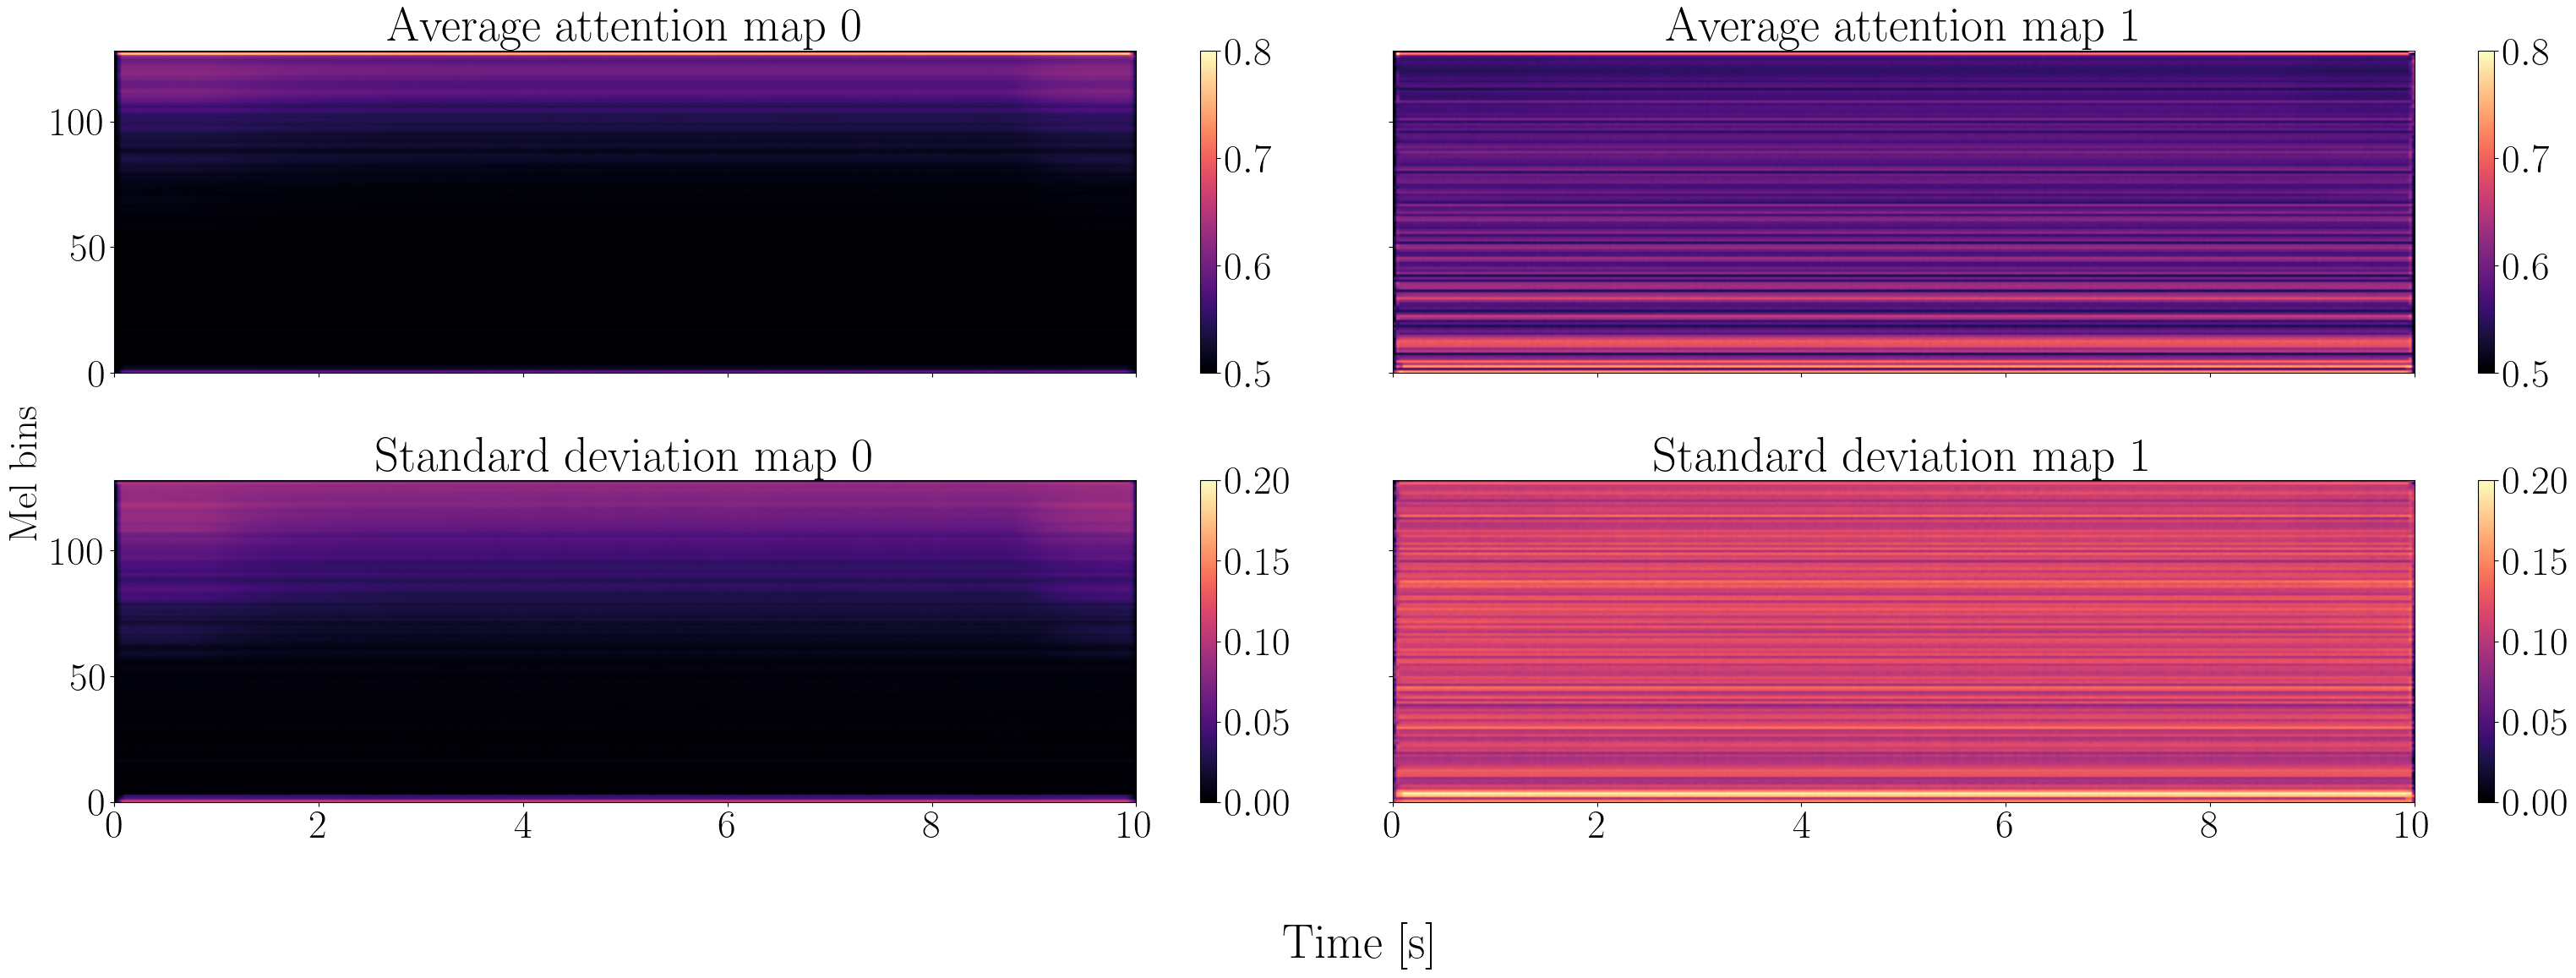

In [12]:
# COMPUTE AVERAGE AND VARIANCE

average_image_0 = torch.mean(list_attention_map_0, 0)
average_image_1 = torch.mean(list_attention_map_1, 0)

std_image_0 = torch.std(list_attention_map_0, 0)
std_image_1 = torch.std(list_attention_map_1, 0)

# RETURN 2X2 SUBPLOTS WHERE WE PLOT
    # - FIRST ROW: AVERAGE OF EACH ATTENTION CHANNEL
    # - SECOND ROW: STANDARD DEVIATION OF EACH ATTENTION CHANNEL

time_steps = np.linspace(0, 10, average_image_0.shape[1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 34
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 2, figsize = (32, 12), sharex = True, sharey = True)

im = axs[0, 0].imshow(average_image_0, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(), 0, average_image_0.shape[0]], vmin = 0.5, vmax = 0.8, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[0, 0])
axs[0, 0].set_title('Average attention map 0')
im = axs[0, 1].imshow(average_image_1, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, average_image_0.shape[0]], vmin = 0.5, vmax = 0.8, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[0, 1])
axs[0, 1].set_title('Average attention map 1')
im = axs[1, 0].imshow(std_image_0, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, average_image_0.shape[0]], vmin = 0, vmax = 0.20, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[1, 0])
axs[1, 0].set_title('Standard deviation map 0')
im = axs[1, 1].imshow(std_image_1, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, average_image_0.shape[0]], vmin = 0, vmax = 0.20, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[1, 1])
axs[1, 1].set_title('Standard deviation map 1')
# fig.suptitle("Average and standard deviation of attention maps")
fig.supxlabel('Time [s]')
# fig.supylabel('Mel bins')
fig.text(0, 0.5, 'Mel bins', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("spec-heat-ave-std.pdf", transparent = True, dpi = 400, bbox_inches='tight')

In [ ]:
fig2, axs2 = plt.subplots(1, 2, figsize = (36, 8), sharex = True, sharey = True)
im = axs2[0].imshow(average_image_0, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, list_mel_spec[0].shape[0]], vmin = 0.5, vmax = 1, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs2[0])
axs2[0].set_title('Average attention map on log-Mel Spectrogram')
axs2[0].set_xlabel('Time [s]')
im = axs2[1].imshow(std_image_0], aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, list_mel_spec[0].shape[0]], vmin = 0., vmax = 0.20, cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs2[1])
axs2[1].set_title("Standard deviation of attention map on log-Mel Spectrogram"))
axs2[1].set_xlabel('Time [s]')

fig2.text(0, 0.5, 'Mel bins', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("spec-mel.pdf", transparent = True, dpi = 400, bbox_inches='tight')

# Mel spectrograms with different window length

In [12]:
import torch
import librosa as lb
import matplotlib.pyplot as plt
from data import TUTDatamodule
import numpy as np

train_data = "TUT Anomaly detection/train"
test_data = "TUT Anomaly detection/test"
datamodule = TUTDatamodule(path_train = train_data, path_test = test_data, sample_rate = 16000, duration = 10, percentage_val = 0.05, batch_size = 16)

test_dataloader = datamodule.test_dataloader()
batch = next(iter(test_dataloader))
x, metadata, label, numerical_label = batch
x = x.numpy()
single_audio = x[0]

torch.Size([128, 157])
torch.Size([128, 313])
torch.Size([128, 626])
torch.Size([128, 1251])


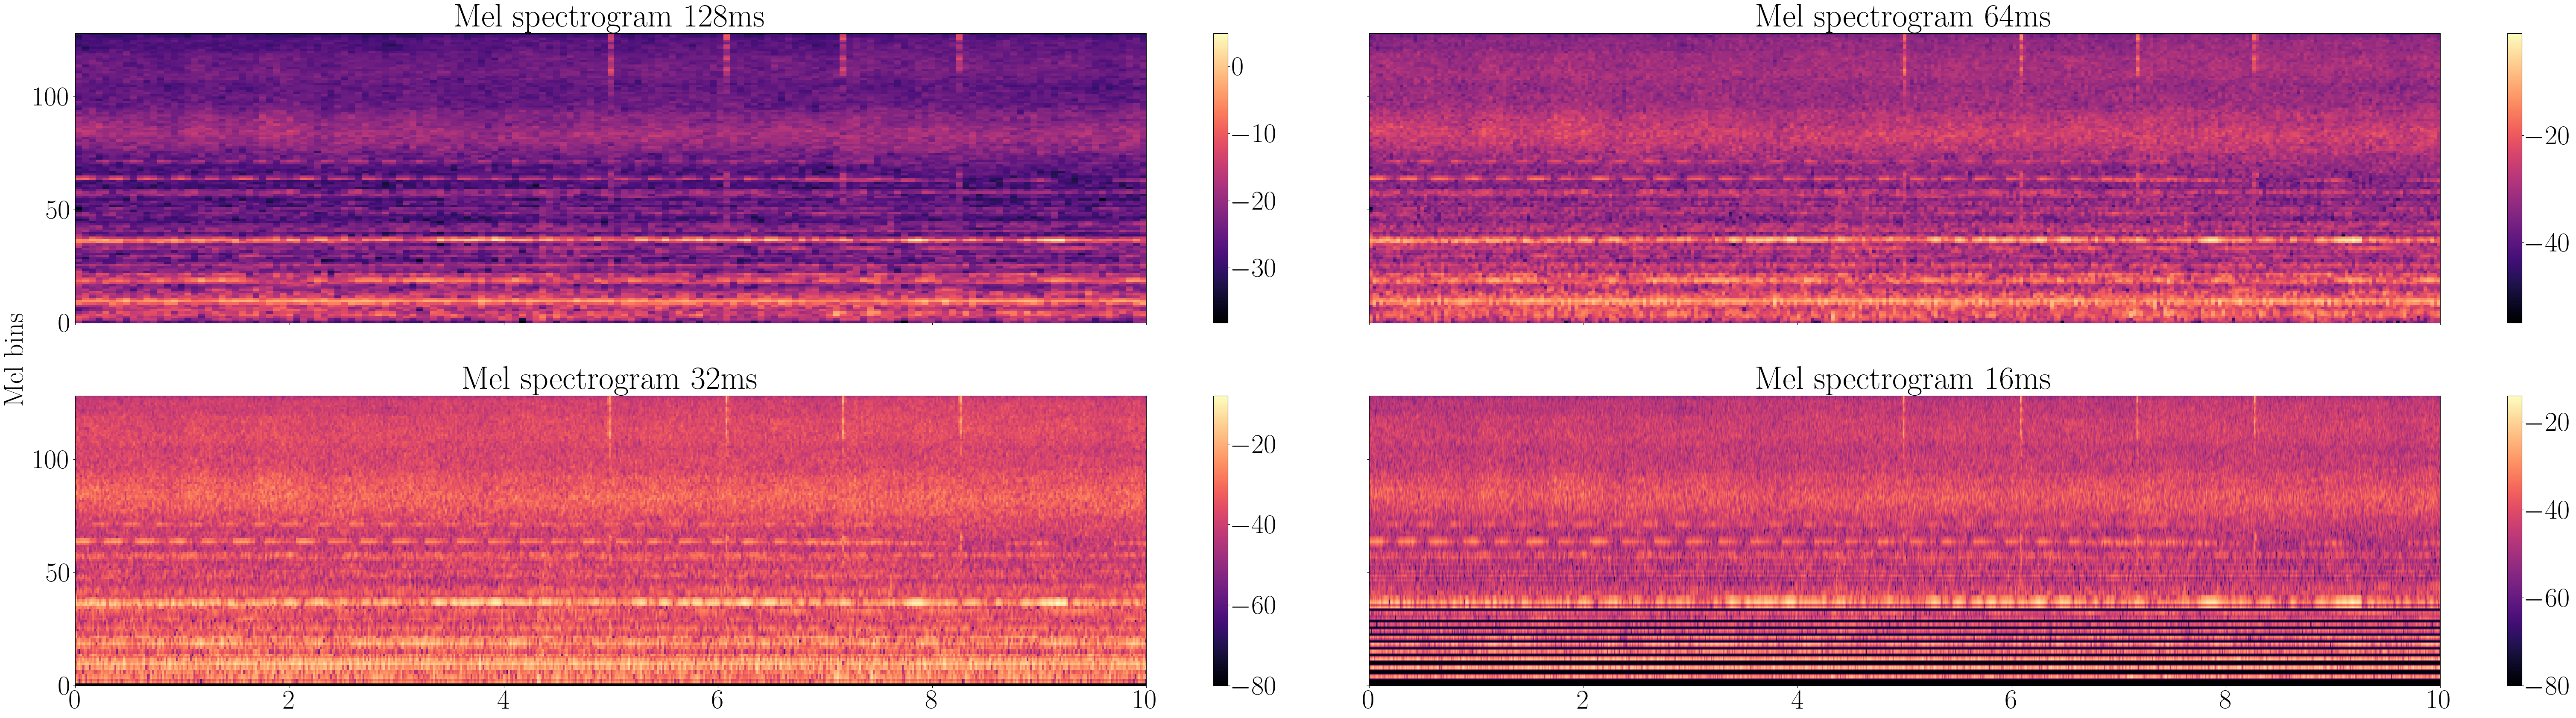

In [22]:
import torchaudio.transforms as T
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 46
plt.rcParams['text.usetex'] = True

ft = T.MelSpectrogram(sample_rate=16000,
                                                n_fft=2048,
                                                win_length=2048,
                                                hop_length=1024,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm="slaney",
                                                n_mels=128,
                                                mel_scale="htk",
                                                )
spec_128 = 10*torch.log10(ft(torch.tensor(single_audio)) + 1e-8)
time_steps = np.linspace(0, 10, spec.shape[1])
print(spec_128.shape)

ft = T.MelSpectrogram(sample_rate=16000,
                                                n_fft=1024,
                                                win_length=1024,
                                                hop_length=512,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm="slaney",
                                                n_mels=128,
                                                mel_scale="htk",
                                                )
spec_64 = 10*torch.log10(ft(torch.tensor(single_audio)) + 1e-8)
print(spec_64.shape)

ft = T.MelSpectrogram(sample_rate=16000,
                                                n_fft=512,
                                                win_length=512,
                                                hop_length=256,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm="slaney",
                                                n_mels=128,
                                                mel_scale="htk",
                                                )
spec_32 = 10*torch.log10(ft(torch.tensor(single_audio)) + 1e-8)    
print(spec_32.shape)
           
ft = T.MelSpectrogram(sample_rate=16000,
                                                n_fft=256,
                                                win_length=256,
                                                hop_length=128,
                                                center=True,
                                                pad_mode="reflect",
                                                power=2.0,
                                                norm="slaney",
                                                n_mels=128,
                                                mel_scale="htk",
                                                )
spec_16 = 10*torch.log10(ft(torch.tensor(single_audio)) + 1e-8)    
print(spec_16.shape)

fig, axs = plt.subplots(2, 2, figsize = (64, 18), sharex = True, sharey = True)

im = axs[0, 0].imshow(spec_128, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(), 0, spec_64.shape[0]], cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[0, 0])
axs[0, 0].set_title('Mel spectrogram $128$ms')
im = axs[0, 1].imshow(spec_64, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, spec_64.shape[0]], cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[0, 1])
axs[0, 1].set_title('Mel spectrogram $64$ms')
im = axs[1, 0].imshow(spec_32, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, spec_64.shape[0]], cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[1, 0])
axs[1, 0].set_title('Mel spectrogram $32$ms')
im = axs[1, 1].imshow(spec_16, aspect='auto', origin='lower', 
           extent=[time_steps.min(), time_steps.max(),  0, spec_64.shape[0]], cmap=plt.get_cmap("magma"))
cbr = plt.colorbar(im, ax = axs[1, 1])
axs[1, 1].set_title('Mel spectrogram $16$ms')
fig.text(0, 0.5, 'Mel bins', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("spec-windows-length.png", transparent = True, dpi = 200, bbox_inches='tight')


